In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk
import colorama as col

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('final_meta/labels')

Label Load Complete


# Embedding Generation

In [4]:
train_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[:-10])
validation_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[-10:])
test_set = Dataset.get_DS(stage='train', labelled='yes')
set_1 = Dataset.get_DS(stage='train', labelled='no')
set_2 = Dataset.get_DS(stage='test', labelled='no')
set_1.append(set_2.data)
set_1.append(train_set.data)
emb_set = set_1
print(emb_set.size, train_set.size, validation_set.size, test_set.size)

4585 238 10 10


In [5]:
#emb_set.process_for_embedding()
#sentences = emb_set.get_sentences()
#fn.write_sentences(sentences, 'final_meta/sentences')
sentences = fn.load_sentences('final_meta/sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('final_meta/W2V')
model = Word2Vec.load('final_meta/W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Window Testing

In [10]:
target = 'm'

train_set.process_for_testing(target)
validation_set.process_for_testing(target)
test_set.process_for_testing(target)

lw, rw = 2, 2
sets = {}
sets['train_set'], sets['train_labels'], sets['train_words'] = train_set.get_ff_sets(model, left_words=lw, right_words=rw)
sets['validation_set'], sets['validation_labels'], sets['validation_words'] = validation_set.get_ff_sets(model, left_words=lw, right_words=rw)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_set.get_ff_sets(model, left_words=lw, right_words=rw)

In [11]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.05% non-med: 0.95%
Ratio: med: 0.13% non-med: 0.87%


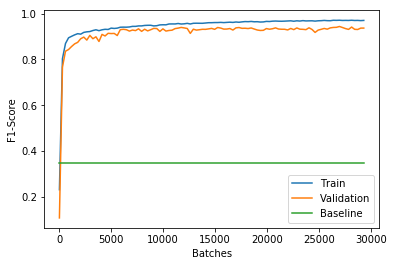

FInal Values: Tr-F1: 0.9701, Val-F1: 0.9367
Test F1-Score: 0.9318



In [12]:
NN = FF_Model(input_size=500, layers=[100], learn_rate=0.001)
NN.build_graph()
results_list = NN.train(sets, epochs=5, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [13]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [14]:
token_perf = fn.token_perf(res, tru)

TP	TN	FP	FN
478	10613	32	38

Precision: 0.9373
Recall: 0.9264
F1-Score: 0.9318


In [15]:
baseline = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.3458814759597465

In [16]:
fn.category_words(sets['test_words'], res, tru, 0, 1)

promote, oxygen, tylenol, insulin, antibiotics, drip, aspirin, insulin, prandial, coverage, current, regimen, dm, regimen, monday-wednesday-friday, flagyl, monday-wednesday-friday, regimen, monday-wednesday-friday, dye, this, hcl, riss, aspirin, motrin, <num>meq, aspirin, broccoli, regimen, ppi, other, medications


In [17]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [18]:
testers = Dataset.get_DS(stage='train', labelled='yes')
phrase_perf = fn.phrase_perf(target, NN, testers, model, side_words=[lw, rw], case_info=True, show_phrases=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


colace [34, 2] [34, 2] colace [34, 2] [34, 2]
insulin lente [34, 7] [34, 8] insulin lente [34, 7] [34, 8]
insulin [36, 2] [36, 2] insulin [36, 2] [36, 2]
isordil [36, 5] [36, 5] isordil [36, 5] [36, 5]
zestril [36, 10] [36, 10] zestril [36, 10] [36, 10]
lopressor [37, 2] [37, 2] lopressor [37, 2] [37, 2]
axid [37, 7] [37, 7] axid [37, 7] [37, 7]
ofloxacin [37, 12] [37, 12] ofloxacin [37, 12] [37, 12]
ecotrin [38, 4] [38, 4] ecotrin [38, 4] [38, 4]
vancomycin [38, 10] [38, 10] vancomycin [38, 10] [38, 10]
heparin [53, 0] [53, 0] heparin [53, 0] [53, 0]
heparin [58, 1] [58, 1] heparin [58, 1] [58, 1]
urokinase [58, 3] [58, 3] urokinase [58, 3] [58, 3]
heparin [66, 8] [66, 8] heparin [66, 8] [66, 8]
coumadin [67, 8] [67, 8] coumadin [67, 8] [67, 8]
vancomycin [70, 2] [70, 2] vancomycin [70, 2] [70, 2]
ofloxacin [70, 9] [70, 9] ofloxacin [70, 9] [70, 9]
antibiotics [71, 5] [71

aspirin [66, 6] [66, 6] aspirin [66, 6] [66, 6]
simvastatin [66, 8] [66, 8] simvastatin [66, 8] [66, 8]
atenolol [68, 3] [68, 3] atenolol [68, 3] [68, 3]
lisinopril [69, 1] [69, 1] lisinopril [69, 1] [69, 1]
nifedipine extended release [69, 6] [69, 8] nifedipine extended release [69, 6] [69, 8]
lasix [74, 5] [74, 5] lasix [74, 5] [74, 5]
lasix [75, 9] [75, 9] lasix [75, 9] [75, 9]
metformin [91, 7] [91, 7] metformin [91, 7] [91, 7]
nph [92, 12] [92, 12] nph [92, 12] [92, 12]
this [95, 8] [95, 8]
atenolol [100, 2] [100, 2] atenolol [100, 2] [100, 2]
hydrochlorothiazide [100, 6] [100, 6] hydrochlorothiazide [100, 6] [100, 6]
lisinopril [101, 2] [101, 2] lisinopril [101, 2] [101, 2]
nifedipine extended release [101, 6] [102, 1] nifedipine extended release [101, 6] [102, 1]
metformin [102, 5] [102, 5] metformin [102, 5] [102, 5]
nph [102, 9] [102, 9] nph [102, 9] [102, 9]
simvastatin [103, 2] [103, 2] simvastatin [103, 2] [103, 2]
aspirin [103, 6] [103, 6] aspirin [103, 6] [103, 6]
lasix [

# HyperParameter Scan

In [ ]:
window_size = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
emb_model = {'CBOW': 0}
layers = [100]
layer_num = [1]
activ = ['sigmoid']
dropouts = [1.0]
learn_rates = [0.01]
epoch_nums = [5]
NN_num = 1

target_names = ['m', 'do', 'mo', 'f', 'du', 'r']

model_num = len(window_size) * len(emb_model) * len(layers) * len(layer_num) * len(activ) * len(dropouts) * len(learn_rates) * len(epoch_nums) * NN_num * len(target_names)


print(model_num)

In [ ]:
#%%capture
n = 0
results = []
for i in range(len(target_names)):
    train_set.process_for_testing(target_names[i])
    validation_set.process_for_testing(target_names[i])
    test_set.process_for_testing(target_names[i])
    timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])
    with open('tests/Model3/' + target_names[i] + '/' + timestamp, 'w+') as f:  
        print('Win:\tVTF1:\tVPF1:\tTTF1:\tTPF1:')
        f.write(target_names[i] + '\n')
        f.write('Win:\tVTF1:\tVPF1:\tTTF1:\tTPF1:\n')
        for win in window_size:
            lw, rw = win, win
            inpsize = 100*(2 * win + 1)
            sets = {}
            sets['train_set'], sets['train_labels'], sets['train_words'] = train_set.get_ff_sets(model, left_words=lw, right_words=rw)
            sets['validation_set'], sets['validation_labels'], sets['validation_words'] = validation_set.get_ff_sets(model, left_words=lw, right_words=rw)
            sets['test_set'], sets['test_labels'], sets['test_words'] = test_set.get_ff_sets(model, left_words=lw, right_words=rw)
            fn.saturate_training_set(sets, 0.1)
            bestvtf1 = 0
            bestvpf1 = 0
            bestttf1 = 0
            besttpf1 = 0
            NN = FF_Model(input_size=inpsize, layers=[100], activ='sigmoid', dropout=1.0, learn_rate=0.01, decay=0.002)
            NN.build_graph()
            for k in range(NN_num):
                n += 1
                print('Model Number: {}/{}'.format(n, model_num), end='\r')
                _, _, _, = NN.train(sets, epochs=5, batch=50)
                valpred = NN.predict(sets['validation_set'])
                if sum(valpred) == len(valpred):
                    valdict = {'f1': 0}
                    valdict2 = {'f1': 0}
                else:
                    valdict = fn.token_perf(res=valpred, tru=np.argmax(sets['validation_labels'], 1), tfpn=False, precision=False, recall=False, f1=False)
                    valdict2 = fn.phrase_perf(target_names[i], NN, validation_set, model, side_words=[lw, rw], tfpn=False, precision=False, recall=False, f1=False)
                bestvtf1 = max(bestvtf1, valdict['f1'])
                bestvpf1 = max(bestvpf1, valdict2['f1'])
                testpred = NN.predict(sets['test_set'])
                if sum(testpred) == len(testpred): 
                    testdict = {'f1': 0}
                    testdict2 = {'f1': 0}
                else:
                    testdict = fn.token_perf(res=testpred, tru=np.argmax(sets['test_labels'], 1), tfpn=False, precision=False, recall=False, f1=False)
                    testdict2 = fn.phrase_perf(target_names[i], NN, test_set, model, side_words=[lw, rw], tfpn=False, precision=False, recall=False, f1=False)
                bestttf1 = max(bestttf1, testdict['f1'])
                besttpf1 = max(besttpf1, testdict2['f1'])
                NN.close()
            results.append([bestvtf1, bestvpf1, bestttf1, besttpf1])
            print('{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(win, *results[-1]))
            f.write('{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\n'.format(win, *results[-1]))

        #print('Max Performance: {:.4f}'.format(max(results)))  
        #f.write('Max Performance: {:.4f}\n'.format(max(results)))

In [ ]:
from matplotlib import pyplot as plt

points = np.array(range(1,11))

mt = [0.889, 0.893, 0.850, 0.854, 0.837, 0.824, 0.830, 0.800, 0.734, 0.771]
dot = [0.945, 0.942, 0.919, 0.934 ,0.917, 0.934, 0.913, 0.897, 0.889, 0.874]
mot = [0.928, 0.932, 0.901, 0.885, 0.918, 0.892, 0.843, 0.867, 0.901, 0.860]
ft = [0.890, 0.905, 0.916, 0.877, 0.902, 0.890, 0.883, 0.897, 0.834, 0.878]
dut = [0.658, 0.707, 0.712, 0.667, 0.682, 0.601, 0.590, 0.669, 0.000, 0.664]
rt = [0.392, 0.416, 0.407, 0.451, 0.424, 0.405, 0.391, 0.405, 0.000, 0.000]

mp = [0.794, 0.797, 0.729, 0.729, 0.696, 0.673, 0.688, 0.636, 0.549, 0.589]
dop = [0.904, 0.884, 0.828, 0.856, 0.849, 0.867, 0.833, 0.784, 0.774, 0.756]
mop = [0.936, 0.922, 0.889, 0.876, 0.915, 0.883, 0.844, 0.866, 0.893, 0.844]
fp = [0.822, 0.844, 0.849, 0.798, 0.829, 0.828, 0.804, 0.833, 0.742, 0.777]
dup = [0.316, 0.339, 0.340, 0.315, 0.310, 0.319, 0.176, 0.296, 0.000, 0.226]
rp = [0.213, 0.256, 0.220, 0.244, 0.217, 0.202, 0.125, 0.182, 0.000, 0.000]


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)

plt.subplot(121)
plt.plot(points, mt, label="m")
plt.plot(points, dot, label="do")
plt.plot(points, mot, label="mo")
plt.plot(points, ft, label="f")
plt.plot(points, dut, label="du")
plt.plot(points, rt, label="r")
plt.xlabel("Window Width")
plt.ylabel("Token-Level Vertical Metric")
plt.title('Token-Level Validation Set Results')
plt.legend()

plt.subplot(122)
plt.plot(points, mp, label="m")
plt.plot(points, dop, label="do")
plt.plot(points, mop, label="mo")
plt.plot(points, fp, label="f")
plt.plot(points, dup, label="du")
plt.plot(points, rp, label="r")
plt.xlabel("Window Width")
plt.ylabel("Phrase-Level Vertical Metric")
plt.title('Phrase-Level Validation Set Results')
plt.legend()

plt.show()